In [4]:
!source ~/.zshrc

In [5]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt

# Establish SodaPy connection
# Establish env variables
username = os.getenv('soc_user')
password = os.getenv('soc_pass')
token = os.getenv('soc_app_token')

# Authenticate client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org", 
                 token, 
                 username=username, 
                 password=password,
                timeout=25)


In [158]:
# Read in neighborhoods
#divvy_stations = gpd.read_file('data/divvy_stations.csv')
chicago = gpd.read_file("data/Community Areas and Ward Boundaries", crs = {'init': 'epsg:4326'})

# Pull Divvy station through socrata API
#station_data = client.get('bk89-9dk7')


In [159]:
# Create Pandas DF to fix long & lat
divvy_data = pd.DataFrame(station_data)

divvy_data['longitude'] = divvy_data['longitude'].apply(lambda x: float(x))
divvy_data['latitude'] = divvy_data['latitude'].apply(lambda x: float(x))

In [160]:
# Move Divvy Station data to GeoDataFrame

all_divvy_stations = gpd.GeoDataFrame(divvy_data, geometry = gpd.points_from_xy(divvy_data['longitude'], divvy_data['latitude']))

# Rename columns
all_divvy_stations.rename(columns={':@computed_region_awaf_s7ux':'Historical Wards 2003-2015',
                              ':@computed_region_6mkv_f3dw':'Zip Codes',
                              ':@computed_region_vrxf_vc4k':'Community Areas',
                              ':@computed_region_bdys_3d7i':'Census Tracts',
                              ':@computed_region_43wa_7qmu':'Wards'},
                     inplace=True)

all_divvy_stations = all_divvy_stations.drop(['Zip Codes', 'location'], axis=1)
divvy_stations.info()
print(divvy_stations.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 581 entries, 0 to 594
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                581 non-null    object  
 1   Wards                       581 non-null    object  
 2   total_docks                 581 non-null    object  
 3   latitude                    581 non-null    float64 
 4   Historical Wards 2003-2015  581 non-null    object  
 5   longitude                   581 non-null    float64 
 6   Census Tracts               581 non-null    object  
 7   status                      581 non-null    object  
 8   Community Areas             581 non-null    object  
 9   docks_in_service            581 non-null    object  
 10  id                          581 non-null    object  
 11  geometry                    581 non-null    geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 59.0+ KB
         

In [161]:
# Inspect Chicago Ward Data
chicago.info()

chicago.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   address     50 non-null     object  
 1   alderman    50 non-null     object  
 2   class       50 non-null     object  
 3   data_admin  53 non-null     float64 
 4   edit_date1  50 non-null     object  
 5   hall_offic  50 non-null     object  
 6   hall_phone  50 non-null     object  
 7   perimeter   53 non-null     float64 
 8   shape_area  53 non-null     float64 
 9   shape_len   53 non-null     float64 
 10  ward        53 non-null     object  
 11  ward_phone  50 non-null     object  
 12  geometry    53 non-null     geometry
dtypes: float64(4), geometry(1), object(8)
memory usage: 5.5+ KB


,address,alderman,class,data_admin,edit_date1,hall_offic,hall_phone,perimeter,shape_area,shape_len,ward,ward_phone,geometry
0,4659 S COTTAGE GROVE STE 203,WILLIAM BURNS,3,9.588452e+07,20030527,"121 N LASALLE ST, RM 300 OFFICE 10, 60602",312-744-2690,71516.462726,9.693978e+07,73428.701824,4,773-536-8103,"POLYGON ((-87.61721 41.84566, -87.61692 41.845..."
1,3649 N KEDZIE AV,RICHARD F. MELL,3,6.278870e+07,20020301,"121 N LASALLE ST, RM 208, 60602",312-744-6825,46189.174036,6.278870e+07,46189.173373,33,773-478-8040,"POLYGON ((-87.69442 41.95564, -87.69443 41.955..."
2,7356 N GREENVIEW AV,JOSEPH A. MOORE,5,4.685230e+07,20030527,"121 N LASALLE ST, RM 300 OFFICE 24, 60602",312-744-3067,44816.944176,4.682849e+07,45091.156684,49,773-338-5796,"POLYGON ((-87.66420 42.02126, -87.66419 42.021..."
3,5344 W NORTH AVE,EMMA MITTS,2,8.526330e+07,20030527,"121 N. LASALLE ST, RM 300, 60602",312-744-8019,60411.795941,8.526330e+07,60411.795499,37,773-745-2894,"POLYGON ((-87.77086 41.92417, -87.77085 41.923..."
4,None,None,None,5.490751e+06,None,None,None,16209.674429,5.475219e+06,16252.000891,OUT,None,"POLYGON ((-87.82815 41.98357, -87.82815 41.983..."


In [179]:
# Define Chicago Side Groups

far_north_side = ['49', '50', '40', '48', '47', '46', '39'] 
northwest_side = ['30', '36', '38', '41', '31', '35', '45']
north_side = ['43', '32', '1', '44', '33']
west_side = ['27', '28', '24', '22', '26', '29', '37', '25']
central = ['42', '2']
south_side = ['20','4', '3', '11']
southwest_side = ['13', '23', '16', '15', '14', '22', '12']
far_southwest_side = ['34', '19', '21', '17', '18']
far_south_side = ['10', '9', '8', '7', '5', '6']
# All Wards List
all_wards = far_north_side + northwest_side + north_side + west_side + central + south_side + far_southwest_side + southwest_side + far_south_side


In [185]:
# Define Function to Assign Groups

def assign_sides(ward):
    if ward in far_north_side:
        return "far north side"
    elif ward in northwest_side:
        return "northwest side"
    elif ward in north_side:
        return "north side"
    elif ward in west_side:
        return "west side"
    elif ward in central:
        return "loop"
    elif ward in south_side:
        return "south side"
    elif ward in southwest_side:
        return "southwest side"
    elif ward in far_southwest_side:
        return "far southwest side"
    elif ward in far_south_side:
        return "far south side"
    else:
        return "None"

In [206]:
# Assign Groups
chicago['side'] = chicago['ward'].apply(lambda x: assign_sides(x))
divvy_stations['side'] = divvy_stations['Wards'].apply(lambda x: assign_sides(x))

# Drop Areas not in City
chicago = chicago[chicago['side']!='None']
divvy_stations[divvy_stations['Wards']=='42']

<ipython-input-206-f0b96627742e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divvy_stations['side'] = divvy_stations['Wards'].apply(lambda x: assign_sides(x))


,station_name,Wards,total_docks,latitude,Historical Wards 2003-2015,longitude,Census Tracts,status,Community Areas,docks_in_service,id,geometry,side


In [198]:
# Remove Stations without Wards
divvy_stations_no_wards = all_divvy_stations[all_divvy_stations['Wards'].isna()==True]
print(divvy_stations_no_wards.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14 entries, 4 to 423
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                14 non-null     object  
 1   Wards                       0 non-null      object  
 2   total_docks                 14 non-null     object  
 3   latitude                    14 non-null     float64 
 4   Historical Wards 2003-2015  0 non-null      object  
 5   longitude                   14 non-null     float64 
 6   Census Tracts               0 non-null      object  
 7   status                      14 non-null     object  
 8   Community Areas             0 non-null      object  
 9   docks_in_service            14 non-null     object  
 10  id                          14 non-null     object  
 11  geometry                    14 non-null     geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 1.4+ KB
None


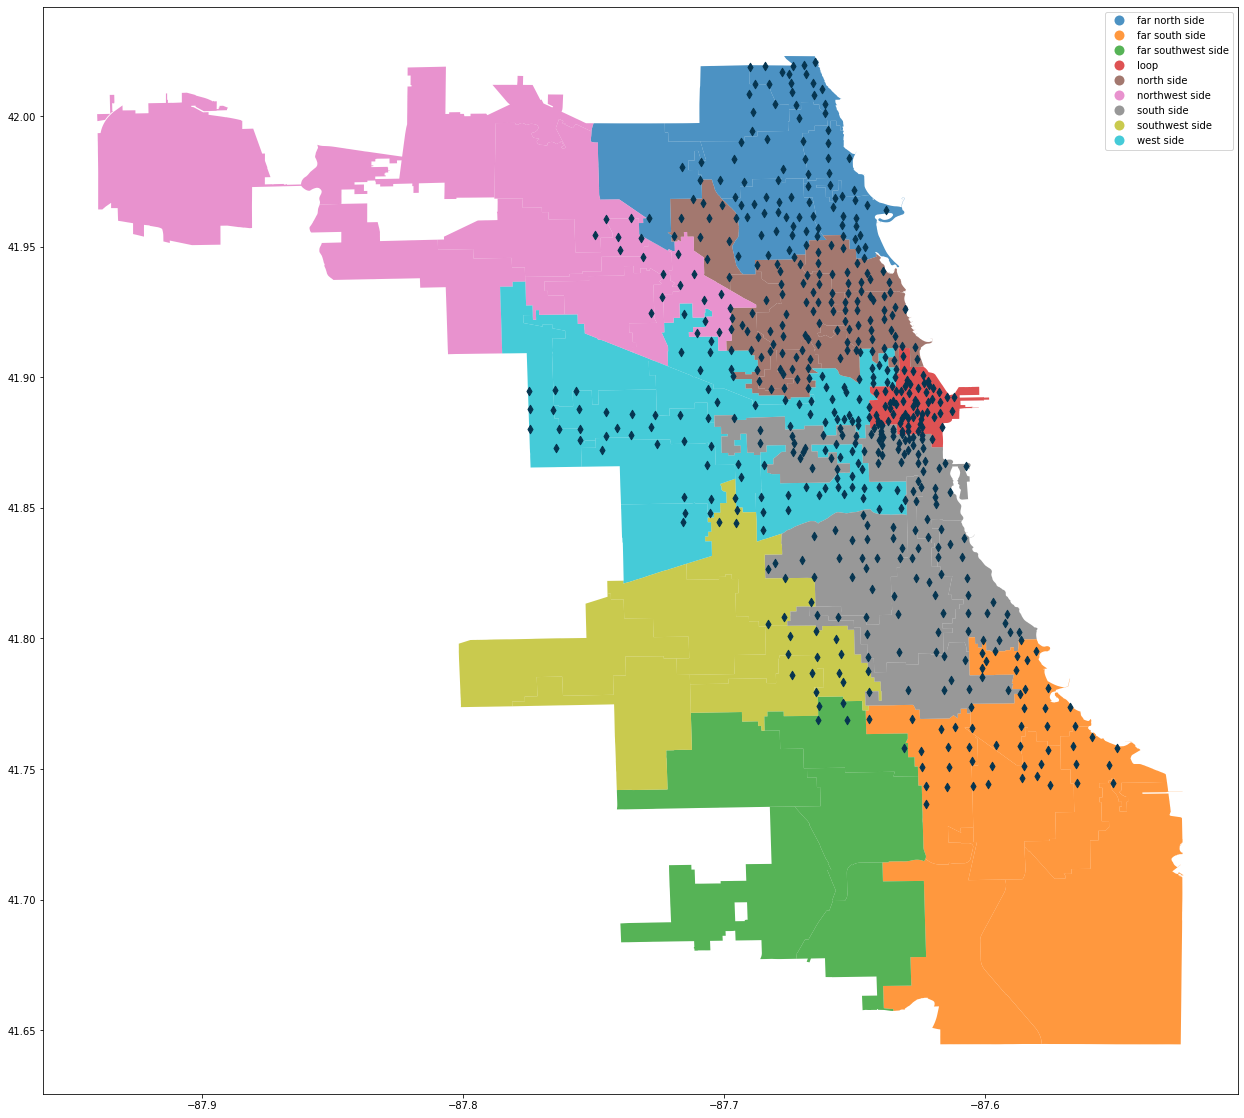

In [199]:
base = chicago.plot(figsize=(30,20), alpha=0.8, column='side', legend = True)

divvy_stations.plot(ax=base, figsize=(30,20), marker ='d', color='#063550')

In [204]:
# High Level Analysis on Divvy stations by general area of Chicago
station_agg_by_side = divvy_stations.groupby('side').agg({'id':'size'})
station_agg_by_side

,id
side,
far north side,115
far south side,79
far southwest side,60
north side,44
northwest side,111
south side,65
southwest side,40
west side,67
